# Stanford Treebank dataset

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
from src.settings import DATA_DIR

DATA_DIR = DATA_DIR.joinpath('stanford_treebank')

df_train = pd.read_csv(DATA_DIR.joinpath('train.tsv'), sep='\t')
df_dev = pd.read_csv(DATA_DIR.joinpath('dev.tsv'), sep='\t')
df_test = pd.read_csv(DATA_DIR.joinpath('test.tsv'), sep='\t')

In [3]:
df_train.head()

,sentence,label
0,The Rock is destined to be the 21st Century 's...,4
1,The gorgeously elaborate continuation of `` Th...,5
2,Singer/composer Bryan Adams contributes a slew...,4
3,You 'd think by now America would have had eno...,3
4,Yet the act is still charming here .,4


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8544 entries, 0 to 8543
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  8544 non-null   object
 1   label     8544 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.6+ KB


In [5]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1101 non-null   object
 1   label     1101 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.3+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2210 entries, 0 to 2209
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2210 non-null   object
 1   label     2210 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.7+ KB


### Concat all splits

In [7]:
df_train['split'] = 'train'
df_dev['split'] = 'val'
df_test['split'] = 'test'

df_all = pd.concat([df_train, df_dev, df_test], ignore_index=True)

### Label distribution

Unique labels: [4 5 3 2 1]


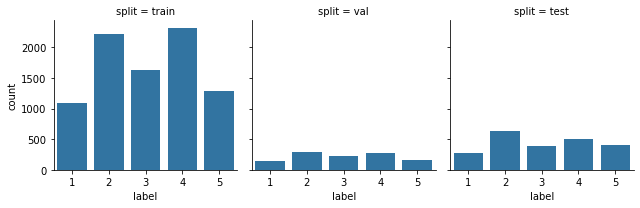

In [8]:
print(f'Unique labels: {df_all.label.unique()}')

g = sns.FacetGrid(df_all, col="split")
g.map(sns.countplot, 'label', order=[1, 2, 3, 4, 5])

### Text length

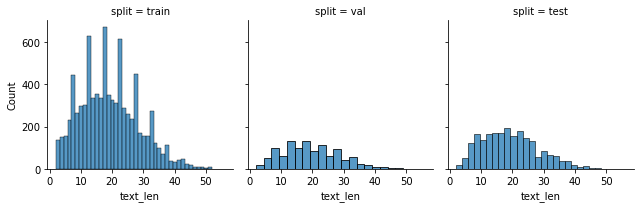

In [9]:
df_all['text_len'] = df_all.sentence.apply(lambda x: len(x.split(' ')))

g = sns.FacetGrid(df_all, col="split")
g.map(sns.histplot, 'text_len')

In [10]:
df_all.describe()

,label,text_len
count,11855.000000,11855.000000
mean,3.055251,19.168705
std,1.287924,9.206627
min,1.000000,2.000000
25%,2.000000,12.000000
50%,3.000000,18.000000
75%,4.000000,25.000000
max,5.000000,56.000000


### Tokenized text lengths

In [11]:
from transformers import AutoTokenizer

HUGGINGFACE_MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(HUGGINGFACE_MODEL_NAME, do_lower_case=True)

texts = df_all['sentence'].values.tolist()

text_tokenized = tokenizer(
    texts,
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=False,
    truncation=False,
    padding=False,
    return_length=True
)
text_tokens = text_tokenized['input_ids']
lengths = text_tokenized['length']

df_all['tok_len'] = lengths
df_all.head()

,sentence,label,split,text_len,tok_len
0,The Rock is destined to be the 21st Century 's...,4,train,36,59
1,The gorgeously elaborate continuation of `` Th...,5,train,37,59
2,Singer/composer Bryan Adams contributes a slew...,4,train,39,50
3,You 'd think by now America would have had eno...,3,train,19,29
4,Yet the act is still charming here .,4,train,8,10


In [12]:
df_all.describe()

,label,text_len,tok_len
count,11855.000000,11855.000000,11855.000000
mean,3.055251,19.168705,26.071615
std,1.287924,9.206627,11.751634
min,1.000000,2.000000,4.000000
25%,2.000000,12.000000,17.000000
50%,3.000000,18.000000,25.000000
75%,4.000000,25.000000,34.000000
max,5.000000,56.000000,72.000000


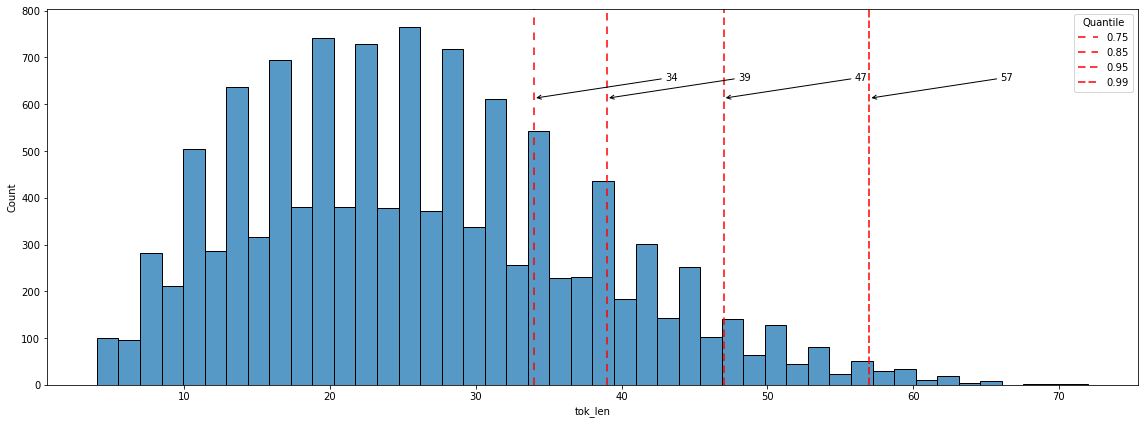

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 6))

sns.histplot(x='tok_len', data=df_all, ax=ax)
max_val = max([p.get_height() for p in ax.patches])
for q, ls in zip([0.75, 0.85, 0.95, 0.99], [(0, (5, 5)), (0, (5, 4)), (0, (5, 3)), (0, (5, 2))]):
    qv = int(df_all['tok_len'].quantile(q))
    ax.axvline(qv, color='red', ls=ls, lw=1.5, label=q)
    ax.annotate(
        qv,
        xy=(qv, max_val * 0.8),
        xytext=(qv + 9, max_val * 0.85),
        arrowprops=dict(arrowstyle="->", color='black'),
    )

ax.legend(title='Quantile')

fig.tight_layout()